# Prior testing for MacNeil *et al.* 2020 *Global status and conservation potential of reef sharks*

In [1]:
# Import packages
%matplotlib inline

import datetime
from itertools import product
import logging
import pickle
import pymc3 as pm
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from theano import tensor as tt
from theano import shared
from collections import Counter
import cmocean as co
import datetime as dt
import matplotlib as mp
import arviz as az

In [2]:
# Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

# Data

### Import FinPrint data

In [3]:
fpdata = pd.read_csv('FinPrint_Set_Data.csv')
fpdata.columns.values

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (23,26,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [4]:
fpdata.Shark_Protection_Status[fpdata.Shark_Protection_Status.isnull()].unique()

array([nan], dtype=object)

In [5]:
fpdata.site_type.unique()

array(['I', 'B', 'A', 'V', 'C', 'O'], dtype=object)

In [6]:
fpdata.shape

(171810, 87)

In [7]:
fpdata.Shark_fishing_restrictions.unique()

array(['Species; Gear; Entrants; Temporal', 'Area; Gear; Species',
       'Species; Bag; Entrants; Gear; Area', 'Area', 'Area; Entrants',
       'Gear', nan, 'Area; Bag; Entrants', 'Gear; Bag; Area', 'Bag; Area',
       'Entrants; Temporal; Gear; Species', 'Entrants; Area',
       'Temporal; Entrants; Species', 'Gear; Species',
       'Area; Entrants; Species', 'Entrants',
       'Temporal; Size; Bag; Entrants; Species', 'Species',
       'Size; Bag; Entrants; Species', 'Species; Gear', 'Species; Bag',
       'Gear; Bag; Species', 'Gear; Species; Bag',
       'Size; Bag; Entrants; Species; Gear', 'Size', 'Entrants; Gear'],
      dtype=object)

In [8]:
# Import location-scale data
ldata = pd.read_csv('Location_Covariates.csv')
ldata.columns.values

array(['FP_location_id', 'FP_location_name', 'CoastLength',
       'FP_location_code', 'EPI', 'Ehealth', 'EcoVitality',
       'EPI_location_name', 'TradeHub', 'GINI_location_name', 'GINI_year',
       'GINI', 'HDI_location_name', 'HDI_year', 'HDI',
       'WGI_location_name', 'Voice_Accountability_year',
       'Voice_Accountability', 'Government_Effectiveness_year',
       'Government_Effectiveness', 'Regulatory_Quality_year',
       'Regulatory_Quality', 'Rule_of_Law_year', 'Rule_of_Law',
       'Control_Corruption_year', 'Control_Corruption',
       'GDP_location_name', 'GDP_year', 'GDP_per_capita_USD',
       'Population_location_name', 'Population_year', 'Population',
       'SAUP_EEZ_name', 'Catch_year', 'Total_catch_tonnes',
       'Total_catch_reported_only', 'Total_catch_value',
       'Reef_catch_tonnes', 'Reef_catch_value', 'Tuna_catch_tonnes',
       'Tuna_catch_value', 'Reefshark_catch_tonnes',
       'Reefshark_catch_value', 'Shark_catch_tonnes', 'Shark_catch_value',
   

In [9]:
critter = 'sharks'

In [10]:
fpdata['functional_group'].unique()

array(['apex', 'benthic_rover', 'guitar', 'pelagic', 'reef_meso',
       'large_ray', 'small_ray', 'coastal_rover', 'nocturnal_invader'],
      dtype=object)

In [11]:
# Grab only sharks
poo = fpdata[fpdata['functional_group'].isin(['reef_meso','apex','coastal_rover','benthic_rover', 'nocturnal_invader'])]

In [12]:
poo.functional_group.unique()

array(['apex', 'benthic_rover', 'reef_meso', 'coastal_rover',
       'nocturnal_invader'], dtype=object)

In [13]:
# Sum maxn's given set id's
tmp = poo.groupby(['set_id'], as_index=False)['maxn'].sum()
tmp.columns = ['set_id','MaxN_shark']

In [14]:
tmp.columns.values

array(['set_id', 'MaxN_shark'], dtype=object)

In [15]:
xdata = fpdata.merge(tmp, on=['set_id']).drop_duplicates(subset=['set_id'])

In [16]:
tmp.loc[tmp.set_id==2635].MaxN_shark

2075    9
Name: MaxN_shark, dtype: int64

In [17]:
np.shape(xdata)

(19090, 88)

In [18]:
# Break out Australia IOT and Dutch Antilles Leeward

xdata.location_name[xdata.site_name=='Ashmore'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Houtman Abrolhos'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Cocos-Keeling'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Christmas Island'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Pedro Bank'] = 'Jamaica PB'
xdata.location_name[xdata.site_name=='Cayo Serranilla'] = 'Columbia SF'
xdata.location_name[xdata.site_name=='Old Providence Island'] = 'Columbia SF'

xdata.location_name[xdata.location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
xdata.location_name[xdata.location_name=='British West Indies '] = 'Montserrat'
ldata.FP_location_name[ldata.FP_location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
ldata.FP_location_name[ldata.FP_location_name=='British West Indies '] = 'Montserrat' 

xdata.location_name[xdata.site_name=='Aruba'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Bonaire'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Curacao'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Saba'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='Saba Bank'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Eustatius'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Maarten'] = 'Dutch Antilles Windward'


/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aaron

In [19]:
xdata.location_name.unique()

array(['USA-Western Atlantic', 'Bahamas', 'Australia-Pacific',
       'Australia IOT', 'Maldives', 'Malaysia', 'Solomon Islands',
       'Indonesia', 'Palau', 'American Samoa', 'New Caledonia', 'Belize',
       'Jamaica', 'Trinidad and Tobago', 'Vanuatu', 'British West Indies',
       'Fiji', 'Colombia', 'Australia-Indian Ocean', 'South Africa',
       'Mozambique', 'Niue', 'Japan', 'Seychelles', 'Taiwan', 'Kiribati',
       'Qatar', 'Federated States of Micronesia', 'Vietnam',
       'Philippines', 'French Polynesia', 'Samoa', 'Turks and Caicos',
       'Antigua and Barbuda', 'Barbados', 'Brazil', 'Columbia SF',
       'Jamaica PB', 'Mayotte', 'USA-Pacific', 'Sri Lanka', 'Tanzania',
       'Papua New Guinea', 'Tonga', 'New Zealand', 'India', 'Kenya',
       'Dutch Antilles Windward', 'Madagascar', 'Saudi Arabia-Red Sea',
       'Guam', 'Cook Islands', 'Dominican Republic', 'French West Indies',
       'Dutch Antilles Leeward', 'Cuba', 'Bermuda', 'Puerto Rico'],
      dtype=object)

In [20]:
np.shape(xdata)

(19090, 88)

In [21]:
# Cut rows with no visibility values
xdata = xdata[np.isfinite(xdata['visibility'])]
# Cut rows with no hard coral values
xdata = xdata[np.isfinite(xdata['hard_coral'])]
# Cut rows with no rugosity values
xdata = xdata[np.isfinite(xdata['substrate_relief_mean'])]

In [22]:
np.shape(xdata)

(15176, 88)

In [23]:
1-15171/15176

0.00032946758039009705

In [24]:
# Remove high leverage observations
xdata = xdata[xdata.set_id!=6783]
xdata = xdata[xdata.set_id!=29122]
xdata = xdata[xdata.set_id!=33986]
xdata = xdata[xdata.set_id!=20819]
xdata = xdata[xdata.set_id!=34989]
xdata = xdata[xdata.set_id!=22974]
xdata = xdata[xdata.set_id!=10335]
xdata = xdata[xdata.set_id!=24488]
xdata = xdata[xdata.set_id!=8863]
xdata = xdata[xdata.set_id!=7255]
xdata = xdata[xdata.set_id!=32874]
np.shape(xdata)

(15165, 88)

In [25]:
xdata.columns.values

array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [26]:
len(xdata.reef_id.unique())

371

In [27]:
xdata.to_csv('FPstudyFinal.csv')

## Models

In [28]:
#Responses
MaxN = xdata.MaxN_shark.values
OCC = (MaxN>0)*1

In [29]:
sum(OCC),sum(OCC)/len(MaxN),len(OCC)

(5719, 0.3771183646554566, 15165)

Code up iterator for analysis

In [30]:
# Hierarchical levels
Reef,Ir = indexall(np.array(xdata.reef_id.values))
nreefs = len(Reef)

Site,Is = subindexall(xdata.site_name.values,xdata.reef_id.values)
nsites = len(Site)

LocationR,Ilr = subindexall(xdata.location_name.values,xdata.reef_id.values)

LocationS,Ils = indexall(xdata.location_name.values)

Location,Il = subindexall(xdata.location_name.values,xdata.site_name.values)
nlocs = len(Location)

Region,Ig = subindexall(xdata.region_name.values,xdata.location_name.values)
nreg = len(Region)

Lox,Ilx = indexall(xdata.site_name.values)

In [31]:
# Lat/lon - national
Lat = np.array([np.mean(xdata.set_latitude.values[xdata.location_name.values==L]) for L in Location])
Lon = np.array([np.mean(xdata.set_longitude.values[xdata.location_name.values==L]) for L in Location])

In [32]:
# Location key
lkey = np.array([list(ldata.FP_location_name.values).index(l) for l in Location])
# Site key
skey = np.array([list(xdata.site_name.values).index(s) for s in Site])
# Reef key
rkey = np.array([list(xdata.reef_id.values).index(r) for r in Reef])

In [33]:
# Check uniqueness
len(xdata.reef_id.unique())/len(xdata.reef_id.values[rkey])

1.0

In [34]:
#"""
# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

In [35]:
ldata.columns

Index(['FP_location_id', 'FP_location_name', 'CoastLength', 'FP_location_code',
       'EPI', 'Ehealth', 'EcoVitality', 'EPI_location_name', 'TradeHub',
       'GINI_location_name', 'GINI_year', 'GINI', 'HDI_location_name',
       'HDI_year', 'HDI', 'WGI_location_name', 'Voice_Accountability_year',
       'Voice_Accountability', 'Government_Effectiveness_year',
       'Government_Effectiveness', 'Regulatory_Quality_year',
       'Regulatory_Quality', 'Rule_of_Law_year', 'Rule_of_Law',
       'Control_Corruption_year', 'Control_Corruption', 'GDP_location_name',
       'GDP_year', 'GDP_per_capita_USD', 'Population_location_name',
       'Population_year', 'Population', 'SAUP_EEZ_name', 'Catch_year',
       'Total_catch_tonnes', 'Total_catch_reported_only', 'Total_catch_value',
       'Reef_catch_tonnes', 'Reef_catch_value', 'Tuna_catch_tonnes',
       'Tuna_catch_value', 'Reefshark_catch_tonnes', 'Reefshark_catch_value',
       'Shark_catch_tonnes', 'Shark_catch_value', 'Bechedemer_catch

In [36]:
## Location-level covariates

# Human development index
HDI = ldata.HDI.values[lkey]

# Voice and accountability
VOICE = ldata.Voice_Accountability.values[lkey]

# Population size
POP = stdize(np.log(ldata.Population.values[lkey]))

# Total catch
CATCH = stdize(np.log(ldata.Reef_catch_tonnes.values[lkey]))

# Shark catch
SCAT = stdize(np.log(ldata.Shark_catch_tonnes.values[lkey]+1))

# Beche de Mer
BDM = stdize(np.log(ldata.Bechedemer_catch_tonnes.values[lkey]+1))

# Tax haven
TAX = ldata.tax_haven.values[lkey]

# Shark sanctuary
SSA = ldata.Shark_Sanctuary.values[lkey]

# Coastline length
CLN = stdize(ldata.CoastLength.values[lkey])

In [37]:
# Site type
STY,Isty = indexall(xdata.site_type.values[skey])
nshabs = len(STY)

#### Reef-level covariates

In [38]:
# Temporary replacement of unknown protection status
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace(np.nan, 'Unknown', regex=True)

In [39]:
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace('Unknown', 'Closed',regex=True)

In [40]:
# Reef habitat type
RTY,Irty = indexall(xdata.reef_type.values[rkey])
nrty = len(RTY)

# Shark protection status
PRO = ['Open', 'Restricted', 'Closed']
Ipro = np.array([PRO.index(x) for x in xdata.Shark_Protection_Status.values[rkey]])
npro = len(PRO)

# Flags for mutual exclusions
CLO = (Ipro==PRO.index('Closed'))*1
noCLO = 1-(Ipro==PRO.index('Closed'))*1
RES = ((Ipro==PRO.index('Restricted'))*(1-(Ipro==PRO.index('Closed'))*1))*1

# MPA size - standardize only places that have area
MPS = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPS!=-999
#MPS[tmp] = stdize(np.log(MPS[tmp]+1))
MPS[tmp] = np.log(MPS[tmp]+1)/max(np.log(MPS[tmp]+1))
MPS[MPS==-999] = 0

# MPA age - standardize only places that have year
MPG = (xdata.mpa_year_founded.fillna(-999+2015).values[rkey]-2015)*-1
tmp = MPG!=999
#MPG[tmp] = stdize(MPG[tmp])
MPG[tmp] = MPG[tmp]/max(MPG[tmp])
MPG[MPG==999] = 0

# High compliance
HIG = (xdata.mpa_compliance.values[rkey]=='high')*1*CLO

# Remote
REM = (xdata.Remote.values[rkey]=='Yes')*1

# Gravity NP
GRAV = stdize(np.log(xdata.Grav_NP.values[rkey]+1))

# Gravity NC
GRAV_NC = stdize(np.log(xdata.Grav_NC.values[rkey]+1))

# Shark gear
xdata.Sharkgear = xdata.Shark_gears.fillna('None')
# Gillnet
GNET = np.array([('Gillnet' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Drumline
DRUM = np.array([('Drumline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Hook and line
HLIN = np.array([('Hook & Line' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Longline
LLIN = np.array([('Longline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Spear
SPE = np.array([('Spear' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Trawl
TRA = np.array([('Trawl' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Blast
BLA = np.array([('Blast' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Gillnets or longlines
GILL = ((GNET+LLIN)>0)*1

# Bag
BAG = np.array([('Bag' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Temporal
TEM = np.array([('Temporal' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Species
SPP = np.array([('Species' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]


# Local population growth
xdata['proportional_difference'] = xdata['population_proporationaldifference_2010.15'].fillna(0)
POPG = stdize(xdata.proportional_difference.values[rkey])

/Users/aaronmacneil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [41]:
# Depth
DEPTH = stdize(xdata.depth.values)

# Bait
tmp = xdata.bait_family.values
tmp[tmp=='Palinuridae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Lutjanidae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Carangidae'] = 'Other'
tmp[tmp=='Belonidae'] = 'Other'
tmp[tmp=='Coryphaenidae'] = 'Other'
tmp[tmp=='Scomberesocidae'] = 'Other'
tmp[tmp=='Osmeridae'] = 'Other'

BAIT,Ib = indexall(tmp)
nbait = len(BAIT)

# Visibility
VIS = stdize(xdata.visibility.values)

# Productivity
tmp = np.median(xdata.set_productivity_2017ave.values[xdata.set_productivity_2017ave.values>0])
xdata.set_productivity_2017ave = xdata.set_productivity_2017ave.fillna(tmp)
PROD = stdize(xdata.set_productivity_2017ave.values-np.mean(xdata.set_productivity_2017ave.values))

# Hard coral
HC = stdize(xdata.hard_coral.values)

# Rugosity
RUG = stdize(xdata.substrate_relief_mean.values)

# Algae
tmp = xdata.macroalgae.fillna(0)
ALG = stdize(tmp.values)

# Noon distance in fractional hours
DAY = np.abs(stdize(np.array([(dt.datetime.strptime(x,'%H:%M:%S')-dt.datetime.strptime('12:00:00','%H:%M:%S')).total_seconds()/60**2 for x in xdata.drop_time.values])))

# Month
MON = np.array([dt.datetime.strptime(x,'%Y-%m-%d').month for x in xdata.set_date.values])

# Hemisphere
HEM = (xdata.set_latitude.values<0)*1

# Seasonality
iSEA = [['Winter','Winter','Shoulder','Shoulder','Summer','Summer','Summer','Summer','Shoulder','Shoulder','Winter','Winter'],['Summer','Summer','Shoulder','Shoulder','Winter','Winter','Winter','Winter','Shoulder','Shoulder','Summer','Summer']]
SEA,Ic = indexall(np.array([iSEA[h][m-1] for h,m in zip(HEM,MON)]))
nsea = len(SEA)

# Number of observations
nobs = len(ALG)

Proportion of zeros

In [42]:
sum(OCC)/len(OCC)

0.3771183646554566

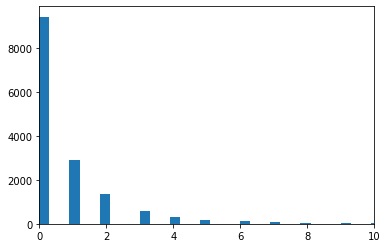

In [43]:
plt.hist(MaxN,bins=100)
plt.xlim(0,10);

In [44]:
nlocs

58

In [45]:
varset = ['Global_rate',
 'CoastLength',
 'Sanctuary',
 'Closed',
 'MPA_size',
 'High_compliance',
 'Gillnet_longline',
 'Drumline',
 'HookLine',
 'Catch',
 'Temporal',
 'Species',
 'Remote',
 'Gravity_NP',
 'Gravity_NC',
 'Depth',
 'Visibililty',
 'Hard_coral',
 'Rugosity',
 'TimeODay',
 'Global_zeros',
 'HDI',
 'VOICE',
 'POP']
nvar = len(varset)

### Full model

In [46]:
nsamps = 2500
prior_list = np.arange(1,9)
npl = len(prior_list)

# Store traces
trace_matrix = np.zeros(shape=(npl,nvar,nsamps*4))


In [47]:
for i in range(npl):

    NPR = prior_list[i]
    
    with pm.Model() as ZINB_full:
        # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
        # Global count model
        π0 = pm.Normal('Global_rate', 0, NPR)
        σ0_υ = pm.Uniform('σ0_υ', 0, 10)
        pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
        υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

        # National count model
        η2 = pm.Normal('Sanctuary', 0, NPR)
        η3 = pm.Normal('CoastLength', 0, NPR)

        η = υ0[Ig]+η2*SSA+η3*CLN
        σ0_η = pm.Uniform('σ0_η', 0, 10)
        η0 = pm.Normal('η0', η, σ0_η, shape=nlocs)

        # Reef-level count model
        κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
        κ1 = tt.set_subtensor(tt.zeros(shape=nrty)[1:], κ1_)

        κ3 = pm.Normal('Closed', 0, NPR)
        κ3a = pm.Normal('MPA_size', 0, NPR)
        κ3b = pm.Normal('High_compliance', 0, NPR)

        κ4 = pm.Normal('Gillnet_longline', 0, NPR)
        κ5 = pm.Normal('Drumline', 0, NPR)
        κ6 = pm.Normal('HookLine', 0, NPR)

        κ7 = pm.Normal('Catch', 0, NPR)
        κ7b = pm.Normal('Temporal', 0, NPR)
        κ7c = pm.Normal('Species', 0, NPR)

        κ8 = pm.Normal('Remote', 0, NPR)
        κ9 = pm.Normal('Gravity_NP', 0, NPR)
        κ10 = pm.Normal('Gravity_NC', 0, NPR)

        # Reef model
        κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC

        σ0_κ = pm.Uniform('σ0_κ',0 , 100)
        κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)

        # = = = Observation model
        ρ1 = pm.Normal('Depth', 0, NPR)

        ρ4 = pm.Normal('Visibililty', 0, NPR)
        ρ5 = pm.Normal('Hard_coral', 0, NPR)
        ρ6 = pm.Normal('Rugosity', 0, NPR)
        ρ7 = pm.Normal('TimeODay', 0, NPR)
        ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
        ρ8 = tt.set_subtensor(tt.zeros(shape=nbait)[1:], ρ8_)
        ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
        ρ9 = tt.set_subtensor(tt.zeros(shape=nsea)[1:], ρ9_)

        μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]

        μ = tt.exp(μ_)

        # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
        # Priors student_t(nu,0,s), with 3<nu<7
        # Global zeros model
        π0_z = pm.Cauchy('Global_zeros', 0, 10)
        σ0_υ_z = pm.Exponential('σ0_υ_z', 1)
        pi0_tilde = pm.Normal('pi0_t', 0, 1, shape=nreg)
        υ0_z = pm.Deterministic('Regional_zeros', π0_z + σ0_υ_z*pi0_tilde)
        σ0_η_z = pm.Exponential('σ0_η_z', 1)

        # National zeros model
        η1_z = pm.Cauchy('HDI', 0, min(max(NPR,3),7))
        η2_z = pm.Cauchy('VOICE', 0, min(max(NPR,3),7))
        η3_z = pm.Cauchy('POP', 0, min(max(NPR,3),7))
        η_z = υ0_z[Ig]+η1_z*HDI+η2_z*VOICE+η3_z*POP
        η0_z = pm.Normal('η0_z', η_z, σ0_η_z, shape=nlocs)

        # Proportion of non-zeros
        ψ = pm.invlogit(η0_z[Ils])

        # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
        α = pm.Gamma('alpha', 0.001, 0.001)
        Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)

        ZINB_full_trace = pm.sample(nsamps)
        
    for j in range(nvar):
        trace_matrix[i][j] = ZINB_full_trace[varset[j]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, η0_z, POP, VOICE, HDI, σ0_η_z, pi0_t, σ0_υ_z, Global_zeros, Seasonality, Bait_type, TimeODay, Rugosity, Hard_coral, Visibililty, Depth, κ0, σ0_κ, Gravity_NC, Gravity_NP, Remote, Species, Temporal, Catch, HookLine, Drumline, Gillnet_longline, High_compliance, MPA_size, Closed, Reef_type, η0, σ0_η, CoastLength, Sanctuary, pi_t, σ0_υ, Global_rate]
Sampling 4 chains: 100%|██████████| 12000/12000 [1:04:42<00:00,  3.09draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9023866226289557, but should be close to 0.8. 

## Prior comparison

In [48]:
trace_matrix.dump("trace_matrixx.dat")

In [49]:
trace_matrix = np.load("trace_matrixx.dat",allow_pickle=True)

In [50]:
nvar

24

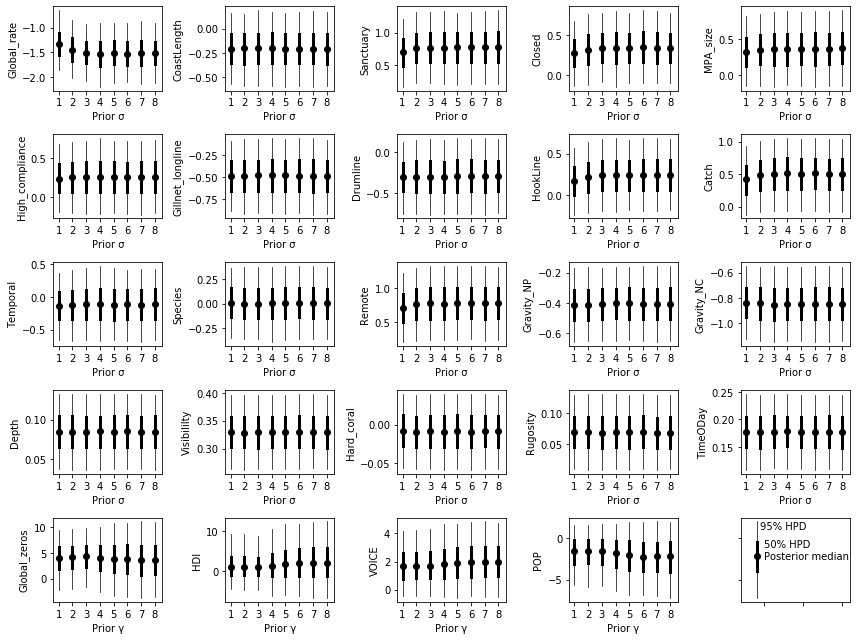

In [56]:
fig = plt.figure(figsize=(12,9))
gs = mp.gridspec.GridSpec(5,5)
ax_ = np.array([fig.add_subplot(gs[i,j]) for i in range(5) for j in range(5)]).reshape(1,25)[0]

for i in range(npl):
    for j in range(nvar):
        ax = ax_[j]
        tracex = trace_matrix[i][j]
        ax.scatter(i+1, np.median(tracex),c='black')
        ax.plot((i+1,i+1), np.quantile(tracex,(0.25,.75)),c='black',linewidth=3)
        ax.plot((i+1,i+1), np.quantile(tracex,(0.05,.95)),c='black',linewidth=.7)

for j in range(nvar-4):
    ax = ax_[j]
    ax.set_xlabel('Prior σ')
    ax.set_ylabel(varset[j])
    ax.set_xticks(range(1,9))
for j in range(nvar-4,nvar):
    ax = ax_[j]
    ax.set_xlabel('Prior γ')
    ax.set_ylabel(varset[j])
    ax.set_xticks(range(1,9))

ax = ax_[24]
ax.scatter(2, np.median(tracex),c='black')
ax.plot((2,2), np.quantile(tracex,(0.25,.75)),c='black',linewidth=3)
ax.plot((2,2), np.quantile(tracex,(0.05,.95)),c='black',linewidth=.7)
ax.set_xlim(1,8)
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(2.2,1.,'95% HPD')
ax.text(2.5,-1.1,'50% HPD')
ax.text(2.5,np.median(tracex)-.4,'Posterior median')

plt.tight_layout()
plt.savefig('ED_Figure_6.pdf');

In [52]:
np.std(POP)

0.5000000000000001